<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2023/24 Semester</h3></th>
    </tr>
</table>

In [ ]:
# Import the Required Packages

from tensorflow import keras
#print('keras: ', keras.__version__)
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import optimizers

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random
import sys


import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.15.0'

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [ ]:
text = open("/content/Harry_Potter_Book.txt", encoding="utf8").read()
print('Corpus length:', len(text))
print(type(text))

Corpus length: 676978
<class 'str'>


Include upper case letters as well as we are trying to mimic a human writing

In [ ]:
text

'/ \n\n\n\n\nOWL POST \n\nHarry Potter was a highly unusual boy in many ways. \nFor one thing, he hated the summer holidays more \nthan any other time of year. For another, he really \nwanted to do his homework but was forced to do it in \nsecret, in the dead of night. And he also happened to \nbe a wizard. \n\nIt was nearly midnight, and he was lying on his \nstomach in bed, the blankets drawn right over his \nhead like a tent, a flashlight in one hand and a large \nleather-bound book (A History of Magic by Bathilda \nBagshot) propped open against the pillow. Harry \nmoved the tip of his eagle-feather quill down the page, \nfrowning as he looked for something that would help \nhim write his essay, “Witch Burning in the Fourteenth \nCentury Was Completely Pointless — discuss.” \n\nThe quill paused at the top of a likely-looking \nparagraph. Harry pushed his round glasses up the \nbridge of his nose, moved his flashlight closer to the \nbook, and read: \n\n\n\nPage | 2 Harry Potter and 

### 1.2 Data Processing


In [ ]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print('\n')
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
print(chars)
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 225640
sentences[0]:  / 




OWL POST 

Harry Potter was a highly unusual boy in m
next_chars[0]:  a


sentences[1]:  



OWL POST 

Harry Potter was a highly unusual boy in many
next_chars[1]:   
Unique characters: 86
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '—', '‘', '’', '“', '”']


In [ ]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(x): ',len(x))
print('x[0]: ',x[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

Vectorization...
len(x):  225640
x[0]:  [[False False False ... False False False]
 [False  True False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]]
len(y):  225640
y[0]:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


In [ ]:
x.shape

(225640, 60, 86)

In [ ]:
split_index = int(0.8 * len(x))

x_train = x[:split_index, :]
x_test = x[split_index:, :]

In [ ]:
y_train = y[:split_index, :]
y_test = y[split_index:, :]

In [ ]:
print(len(x_train))
print(len(y_train))

180512
180512


#### Data Augmentation

In [ ]:
import random

def random_deletion(text, p=0.005):
    characters = list(text)
    for i in range(len(characters)):
        if random.uniform(0, 1) < p:
            characters[i] = ''
    return ''.join(characters)

def random_insertion(text, p=0.005):
    characters = list(text)
    for i in range(len(characters)):
        if random.uniform(0, 1) < p:
            characters.insert(i, random.choice('abcdefghijklmnopqrstuvwxyz'))
    return ''.join(characters)

In [ ]:
augmented_text_deletion = random_deletion(text)
augmented_text_insertion = random_insertion(augmented_text_deletion)

In [ ]:
augmented_text_insertion

'/ \n\n\n\n\nOWL POST \n\nHarry Potter was a highly unsual boy in may ways. \nFor one thing, he fhated the summer holidays more \nthan any other time of year. Fdor another, he really \nwanted to d his homwork but was fworced to do it in \nsecret, in the dead of night. And he also happened to \nbe a wizard. \n\nIt was nearly midnight, and he was lying on his \nstomach in bed, the blankets drawn right over his \nhead like a tent, a flashlight in one hand and a large \nleather-bound book (A Hstory of Magic by Bathilda \nBagshot) prpped open against the pillow. Harry \nmoved the tip of his eagle-feather quill down the page, \nfrowning as he mlooked for something that would help \nhim write his essay, “Witch Burning in the Fourteenth \nCentury Was Completely Pointless — discuss.” \n\nTjhe quill paused at the top of a likely-looking \nparagraph. Harry pushed his round glasses up the \nbridge of his nose, moved his flashlight closer to the \nbook, and read: \n\n\n\nage | 2 Harry Potter and th

In [ ]:
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(augmented_text_insertion) - maxlen, step):
    sentences.append(augmented_text_insertion[i: i + maxlen])
    next_chars.append(augmented_text_insertion[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print('\n')
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])

# List of unique characters in the corpus
chars = sorted(list(set(augmented_text_insertion)))
print('Unique characters:', len(chars))
print(chars)
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 225644
sentences[0]:  / 




OWL POST 

Harry Potter was a highly unsual boy in ma
next_chars[0]:  y


sentences[1]:  



OWL POST 

Harry Potter was a highly unsual boy in may w
next_chars[1]:  a
Unique characters: 86
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '—', '‘', '’', '“', '”']


In [ ]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(x): ',len(x))
print('x[0]: ',x[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

Vectorization...
len(x):  225644
x[0]:  [[False False False ... False False False]
 [False  True False ... False False False]
 [ True False False ... False False False]
 ...
 [False  True False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
len(y):  225644
y[0]:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False]


In [ ]:
split_index = int(0.8 * len(x))

x_train_augmented = x[:split_index, :]
x_test_augmented = x[split_index:, :]

In [ ]:
y_train_augmented = y[:split_index, :]
y_test_augmented = y[split_index:, :]

In [ ]:
print(len(x_train_augmented))
print(len(y_train_augmented))

180515
180515


## Step 2 – Develop Character Generator Model

In [ ]:
import tensorflow.keras.backend as K

In [64]:
def plot_results(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].plot(history["acc"], label="Train Accuracy")
    ax[0].plot(history["val_acc"], label="Validation Accuracy")

    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[0].legend()

    ax[1].plot(history["loss"], label="Train Loss")
    ax[1].plot(history["val_loss"], label="Val Loss")

    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    ax[1].legend()

    plt.show()

def plot_results_multi(histories, labels):
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))

    titles = ["accuracy", "val_accuracy", "loss", "val_loss"]

    for history, label in zip(histories, labels):
        ax[0, 0].plot(history.history["acc"], label=label)
        ax[0, 1].plot(history.history["val_acc"], label=label)
        ax[1, 0].plot(history.history["loss"], label=label)
        ax[1, 1].plot(history.history["val_loss"], label=label)

    for i, title in zip(ax.ravel(), titles):
        i.legend()
        i.set_title(title)

    plt.show()

def calculate_perplexity(model, X_test, y_test):
    # Predict probabilities for each class
    predictions = model.predict(X_test)

    # Flatten the arrays
    predictions_flat = predictions.flatten()
    y_test_flat = y_test.flatten()

    # Calculate negative log likelihood
    nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])

    # Calculate and return perplexity
    perplexity = np.exp(np.mean(nll))
    return perplexity

def evaluate_model(model):
  model_history = model.history.history
  result = {}

  #result['train_loss'] = model_history['loss']
  #result['val_loss'] = model_history['val_loss']
  result['train_perplexity'] = calculate_perplexity(model,x_train,y_train)
  result['val_perplexity'] = calculate_perplexity(model,x_test,y_test)

  result_series = pd.Series(result)
  return result_series

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"



def calculate_bleu_score(reference_sequence, predicted_sequence):
    # Tokenize reference and predicted sequences at the character level
    reference_tokens = list(reference_sequence)
    predicted_tokens = list(predicted_sequence)

    # Calculate BLEU score with smoothing
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=SmoothingFunction().method3)
    return bleu_score

def create_new_text(model):
  #start_index = random.randint(0, len(text) - maxlen - 1)
  start_index = 60
  generated_text_initial = text[start_index: start_index + maxlen]
  print('--- Generating with seed: "' + generated_text_initial + '"')
  for temperature in [0.2, 0.5, 1.0]: # reduce range of temperature
      generated_text = generated_text_initial
      print('------ temperature:', temperature)
      sys.stdout.write(generated_text)

            # We generate 100 characters
      for i in range(100):
          sampled = np.zeros((1, maxlen, len(chars)))
          for t, char in enumerate(generated_text):
              sampled[0, t, char_indices[char]] = 1.

          preds = model.predict(sampled, verbose=0)[0] # to get the softmax output
          next_index = sample(preds, temperature)
          next_char = chars[next_index]

          generated_text += next_char
          generated_text = generated_text[1:]

          sys.stdout.write(next_char)
          sys.stdout.flush()

      bleu_score = calculate_bleu_score(generated_text_initial, generated_text)
      print("\n BLEU Score:", bleu_score)

      print()



### Model 1: Base Model LSTM

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 128)               110080    
                                                                 
 dense_37 (Dense)            (None, 86)                11094     
                                                                 
Total params: 121174 (473.34 KB)
Trainable params: 121174 (473.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs = 20, batch_size=64,
          validation_split = 0.2)

Epoch 1/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.9764 - acc: 0.4465 - val_loss: 1.6838 - val_acc: 0.5175
Epoch 2/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5989 - acc: 0.5399 - val_loss: 1.5662 - val_acc: 0.5492
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5035 - acc: 0.5627 - val_loss: 1.5332 - val_acc: 0.5578
Epoch 4/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4646 - acc: 0.5737 - val_loss: 1.5411 - val_acc: 0.5598
Epoch 5/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4236 - acc: 0.5834 - val_loss: 1.5049 - val_acc: 0.5708
Epoch 6/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.3891 - acc: 0.5934 - val_loss: 1.4884 - val_acc: 0.5732
Epoch 7/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.3639 - acc: 0.5988 - val_loss: 1.4953 - val_acc: 0.5760
Epoch 8/20
2257/2257 [==============================] -

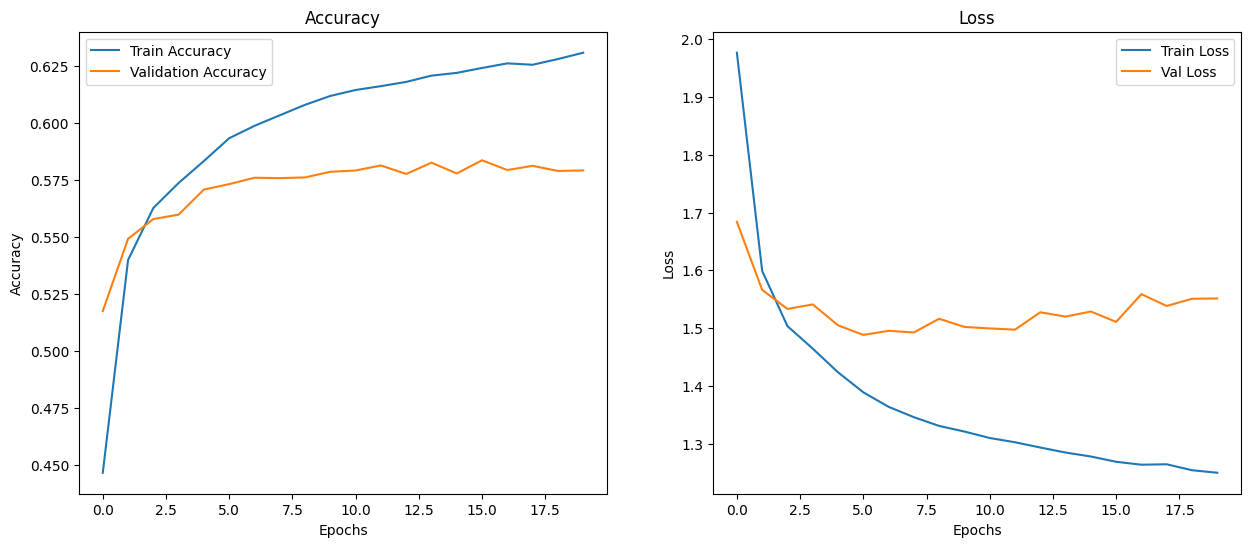

In [ ]:
plot_results(history.history)

We see some overfitting in the model. Deviation between curves and very slight increase in val loss with decreasing train loss

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more to the end of the stairs 
and a stairs at the stairs 
and said all the stairs and shapped the stairs
 BLEU Score: 0.21956630744435

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more around the last the end of the stort class was a staers and break the castle and what was a standing
 BLEU Score: 0.16042679718893807

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more though 
the Lellele, telling it from the 
suspicious beats of all, who was nudyed his streed 
that t
 BLEU Score: 0.09980022654246413



### Model 2: LSTM Data Augmentation 

#### Data Augmentation (P = 0.01)

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 128)               110080    
                                                                 
 dense_38 (Dense)            (None, 86)                11094     
                                                                 
Total params: 121174 (473.34 KB)
Trainable params: 121174 (473.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(x_train_augmented, y_train_augmented, epochs = 20, batch_size=64,
          validation_split = 0.2)

Epoch 1/20
2257/2257 [==============================] - 14s 6ms/step - loss: 2.0553 - acc: 0.4313 - val_loss: 1.7843 - val_acc: 0.4996
Epoch 2/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.6962 - acc: 0.5207 - val_loss: 1.6764 - val_acc: 0.5299
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.6010 - acc: 0.5470 - val_loss: 1.6453 - val_acc: 0.5414
Epoch 4/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5459 - acc: 0.5613 - val_loss: 1.6316 - val_acc: 0.5469
Epoch 5/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5132 - acc: 0.5690 - val_loss: 1.6106 - val_acc: 0.5536
Epoch 6/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4869 - acc: 0.5770 - val_loss: 1.6120 - val_acc: 0.5564
Epoch 7/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4644 - acc: 0.5833 - val_loss: 1.6144 - val_acc: 0.5580
Epoch 8/20
2257/2257 [==============================] -

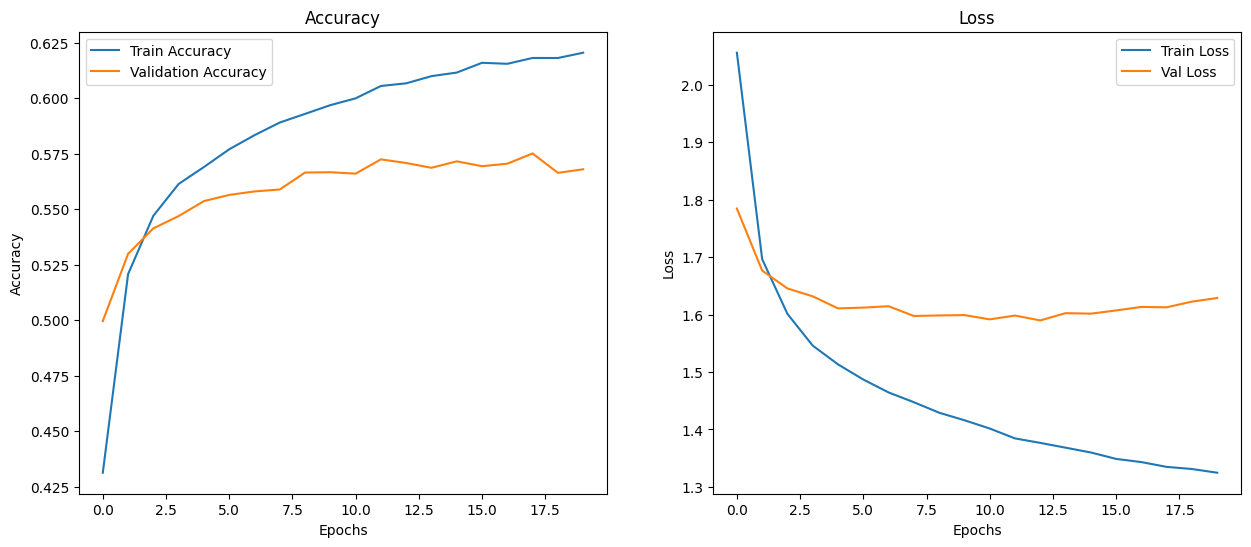

In [ ]:
plot_results(history.history)

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
wand to the table and should have looked at the 
handly a sudden whole was a suck and started of 
h
 BLEU Score: 0.20622600508057767

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
and the corridor of the start of the holidays on the 
outside to had a portat 1ass it the end of 
h
 BLEU Score: 0.28657760640807217

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
becouily. “Un, I’d shoped your near onen?” 

Harry was sriping the bed, exprawed him shrind her 
ea
 BLEU Score: 0.2148732764007298



#### Data Augmentation (P = 0.005)

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

In [ ]:
history = model.fit(x_train_augmented, y_train_augmented, epochs = 20, batch_size=64,
          validation_split = 0.2)

Epoch 1/20
2257/2257 [==============================] - 16s 6ms/step - loss: 2.0567 - acc: 0.4320 - val_loss: 1.7840 - val_acc: 0.4997
Epoch 2/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.6978 - acc: 0.5212 - val_loss: 1.6808 - val_acc: 0.5325
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5976 - acc: 0.5476 - val_loss: 1.6416 - val_acc: 0.5459
Epoch 4/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5450 - acc: 0.5612 - val_loss: 1.6218 - val_acc: 0.5532
Epoch 5/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.5082 - acc: 0.5707 - val_loss: 1.6081 - val_acc: 0.5545
Epoch 6/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4853 - acc: 0.5762 - val_loss: 1.6074 - val_acc: 0.5556
Epoch 7/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.4623 - acc: 0.5825 - val_loss: 1.6043 - val_acc: 0.5605
Epoch 8/20
2257/2257 [==============================] -

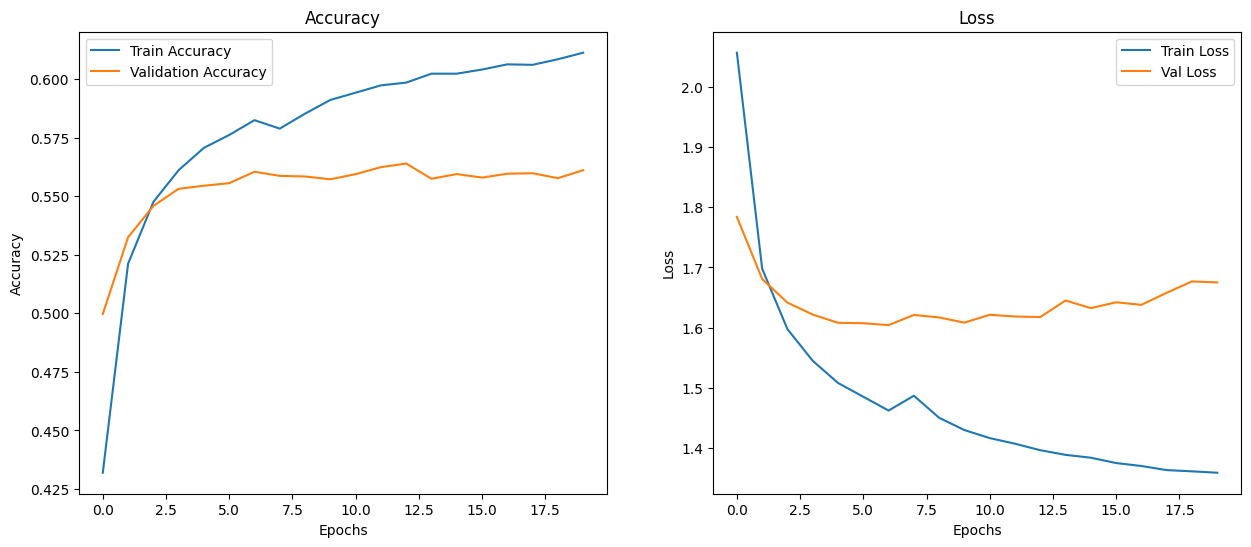

In [ ]:
plot_results(history.history)

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
that the train the corridors and then he was a class. 

“What was the trunk to the train and the tr
 BLEU Score: 0.24138405509713015

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
— 

Dumbledore and the trunk eyes 
this in the 
Snweak a really an he wasn’t had been 
the 
hands a
 BLEU Score: 0.19703715011933906

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more still wanding with around his 
class reminds his and 
though bitter flaves, still 
acently, Ron, now
 BLEU Score: 0.07202795932249301



### Model 3: LSTM RMSProp Learning Rates**


In [ ]:
hyperparameter_name = 'learning_rate'
params = {hyperparameter_name :[0.001, 0.005, 0.01, 0.1]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = value)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

learning_rate 0.001
model 0.001
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 128)               110080    
                                                                 
 dense_39 (Dense)            (None, 86)                11094     
                                                                 
Total params: 121174 (473.34 KB)
Trainable params: 121174 (473.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 15s 6ms/step - loss: 2.5841 - acc: 0.3030 - val_loss: 2.2368 - val_acc: 0.3785
Epoch 2/20
2257/2257 [==============================] - 12s 5ms/step - loss: 2.1215 - acc: 0.4086 - val_loss: 2.0119 - val_acc: 0.4393
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.9457 - acc: 0.4530 - val_los

<ipython-input-108-94b099702fc5>:50: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])


1411/1411 [==============================] - 3s 2ms/step


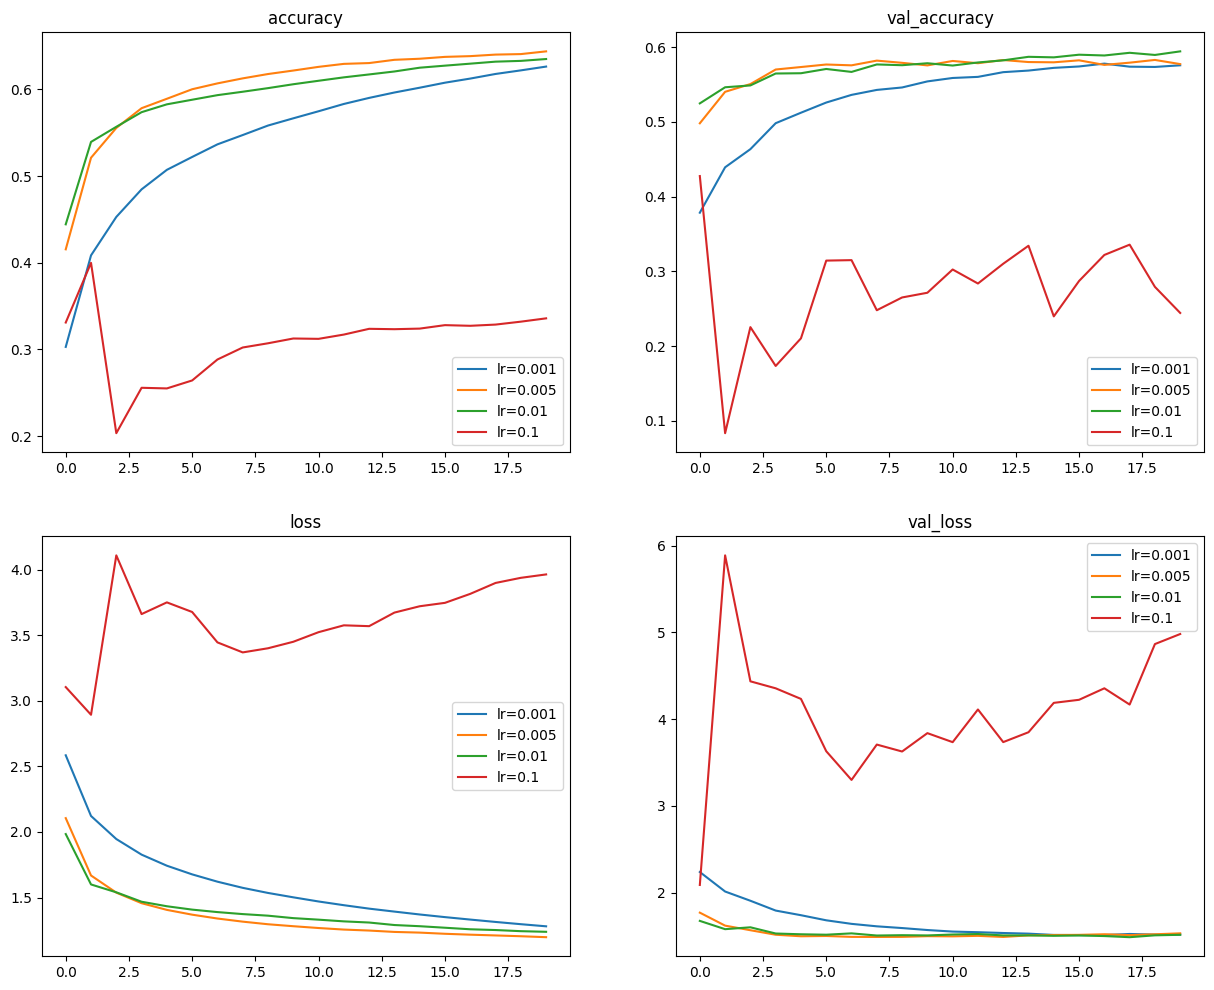

In [ ]:
plot_results_multi(histories, ["lr=0.001", "lr=0.005","lr=0.01","lr=0.1"])

Use learning rate of 0.01

In [ ]:
selected_value = 0.01  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
had been a sessorrowed the trained at the table. 

“Well are you think it to see it to the team to 
 BLEU Score: 0.2209259161048557

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
as they stared as though he was started along to 
the beash and seriously, “I see you do some dong,
 BLEU Score: 0.11719882010212058

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
severus for beli?utors about Muggle Ron’s are Black 
undermind the Boy sitting sure might — “un of 
 BLEU Score: 0.19415992307791144



### Model 4: LSTM Batch Sizes

In [ ]:
hyperparameter_name = 'batch_size'
params = {hyperparameter_name :[16, 32, 64, 128]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=value,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

batch_size 16
model 16
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 128)               110080    
                                                                 
 dense_43 (Dense)            (None, 86)                11094     
                                                                 
Total params: 121174 (473.34 KB)
Trainable params: 121174 (473.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
9026/9026 [==============================] - 50s 5ms/step - loss: 1.9764 - acc: 0.4587 - val_loss: 1.8343 - val_acc: 0.5028
Epoch 2/20
9026/9026 [==============================] - 47s 5ms/step - loss: 1.7827 - acc: 0.5107 - val_loss: 1.7817 - val_acc: 0.5215
Epoch 3/20
9026/9026 [==============================] - 47s 5ms/step - loss: 1.7767 - acc: 0.5179 - val_loss: 1.8392

<ipython-input-108-94b099702fc5>:50: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])


1411/1411 [==============================] - 4s 2ms/step
batch_size 32
model 32
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 128)               110080    
                                                                 
 dense_44 (Dense)            (None, 86)                11094     
                                                                 
Total params: 121174 (473.34 KB)
Trainable params: 121174 (473.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
4513/4513 [==============================] - 26s 6ms/step - loss: 1.9438 - acc: 0.4584 - val_loss: 1.7008 - val_acc: 0.5243
Epoch 2/20
4513/4513 [==============================] - 24s 5ms/step - loss: 1.6434 - acc: 0.5339 - val_loss: 1.6200 - val_acc: 0.5415
Epoch 3/20
4513/4513 [==============================] - 23s

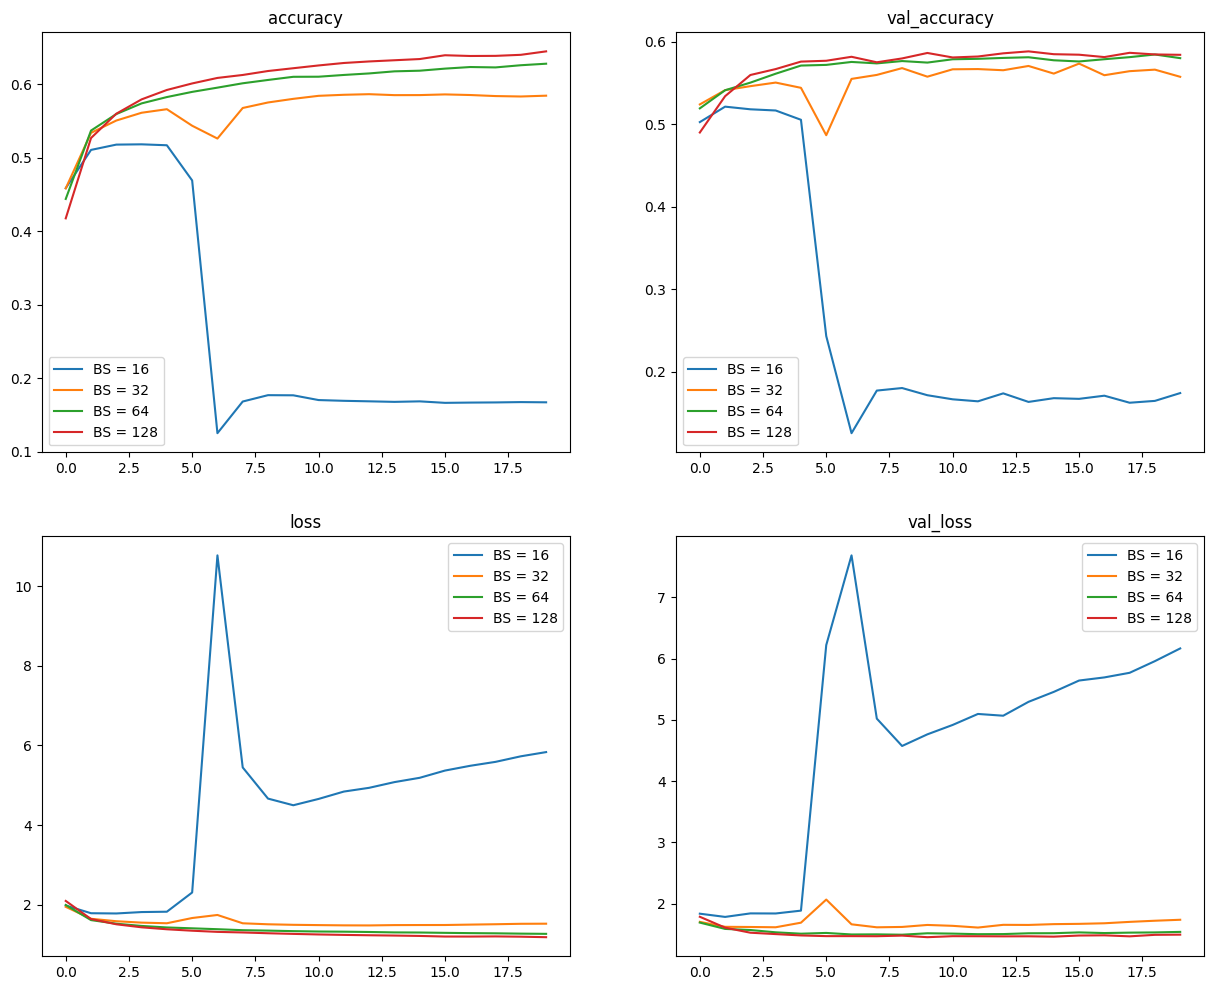

In [ ]:
plot_results_multi(histories, ["BS = 16", "BS = 32", "BS = 64", "BS = 128"])

Use batch size 64

In [ ]:
selected_value = 64  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more was 
staring to 
see a suddenly staring to see it with the staircast 
himself to 
see if Hermione sh
 BLEU Score: 0.19267199793661316

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
and same. He was still sispecked it around a very speaks and 
puspaning from the end of the stairca
 BLEU Score: 0.1952538250791992

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more had to 
Ron Harry packened all 
you — ” 

Percy, novon to help from her bit disspyeen into Harry’s w
 BLEU Score: 0.08241796975945151



### Model 5: LSTM Layer Size

In [ ]:
hyperparameter_name = 'layer_size'
params = {hyperparameter_name :[64, 96, 128, 160]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(value, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

layer_size 64
model 64
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                38656     
                                                                 
 dense_1 (Dense)             (None, 86)                5590      
                                                                 
Total params: 44246 (172.84 KB)
Trainable params: 44246 (172.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 16s 6ms/step - loss: 2.0780 - acc: 0.4215 - val_loss: 1.7852 - val_acc: 0.4907
Epoch 2/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.7078 - acc: 0.5121 - val_loss: 1.6749 - val_acc: 0.5250
Epoch 3/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.6206 - acc: 0.5354 - val_loss: 1.6321 - 

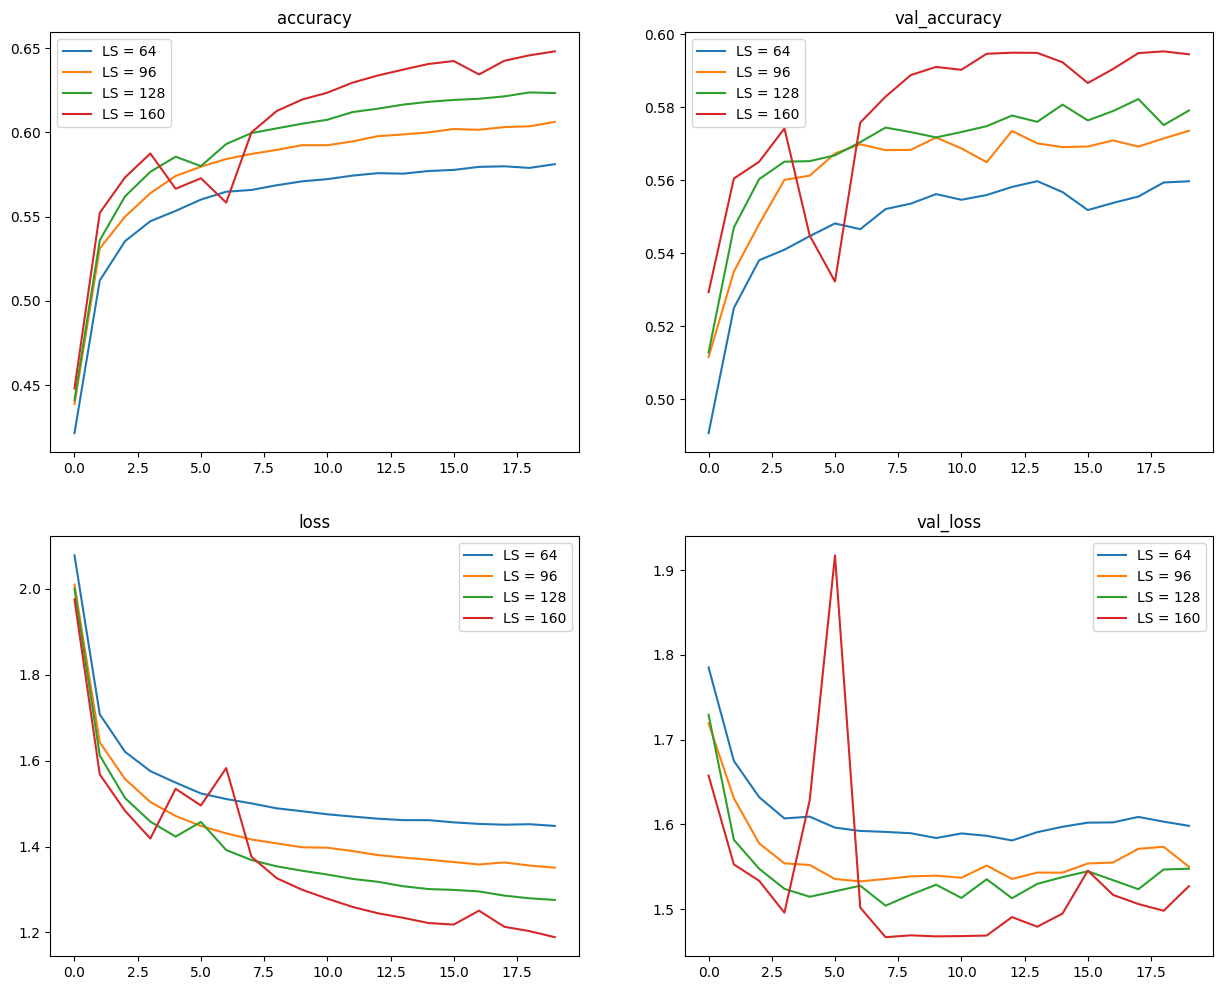

In [ ]:
plot_results_multi(histories, ["LS = 64", "LS = 96", "LS = 128", "LS = 160"])

Use 160

In [ ]:
selected_value = 160  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
the train and she was a classroom. 

“And it’s not we to see you the other the morning. I 
they wer
 BLEU Score: 0.23991722184453992

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
the pacess. 

“And it’s pare were you started to the Sirryfle, I will 
in the matter with the Mallo
 BLEU Score: 0.22545969693955956

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
furious, drost getting feel from the teachers and 
the portrait by histered, which everyone were th
 BLEU Score: 0.20863841530469543



#### Try even higher layer sizes

In [ ]:
hyperparameter_name = 'layer_size'
params = {hyperparameter_name :[160, 192, 224, 256]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(value, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

layer_size 160
model 160
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 160)               158080    
                                                                 
 dense_5 (Dense)             (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 17s 7ms/step - loss: 1.9580 - acc: 0.4520 - val_loss: 1.6758 - val_acc: 0.5226
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.5660 - acc: 0.5507 - val_loss: 1.5421 - val_acc: 0.5593
Epoch 3/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.4621 - acc: 0.5764 - val_loss: 1.481

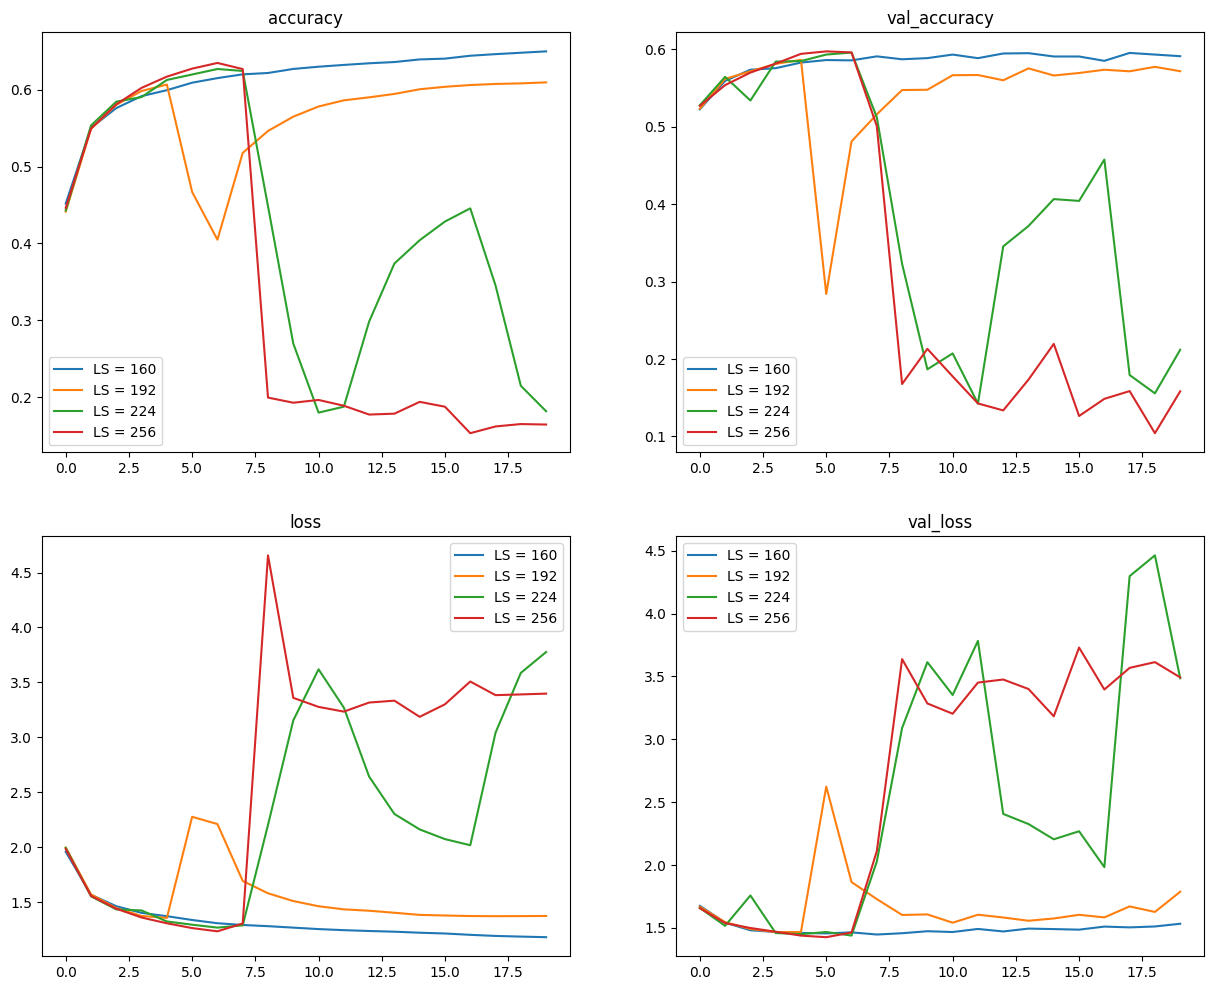

In [ ]:
plot_results_multi(histories, ["LS = 160", "LS = 192", "LS = 224", "LS = 256"])


Continue using LS 160

### Final LSTM Model

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(160, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()


history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 160)               158080    
                                                                 
 dense_10 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 16s 6ms/step - loss: 1.9685 - acc: 0.4490 - val_loss: 1.6632 - val_acc: 0.5257
Epoch 2/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.5747 - acc: 0.5477 - val_loss: 1.5488 - val_acc: 0.5531
Epoch 3/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.4740 - acc: 0.5741 - val_loss: 1.4915 - val_acc: 0.5758
Epoc

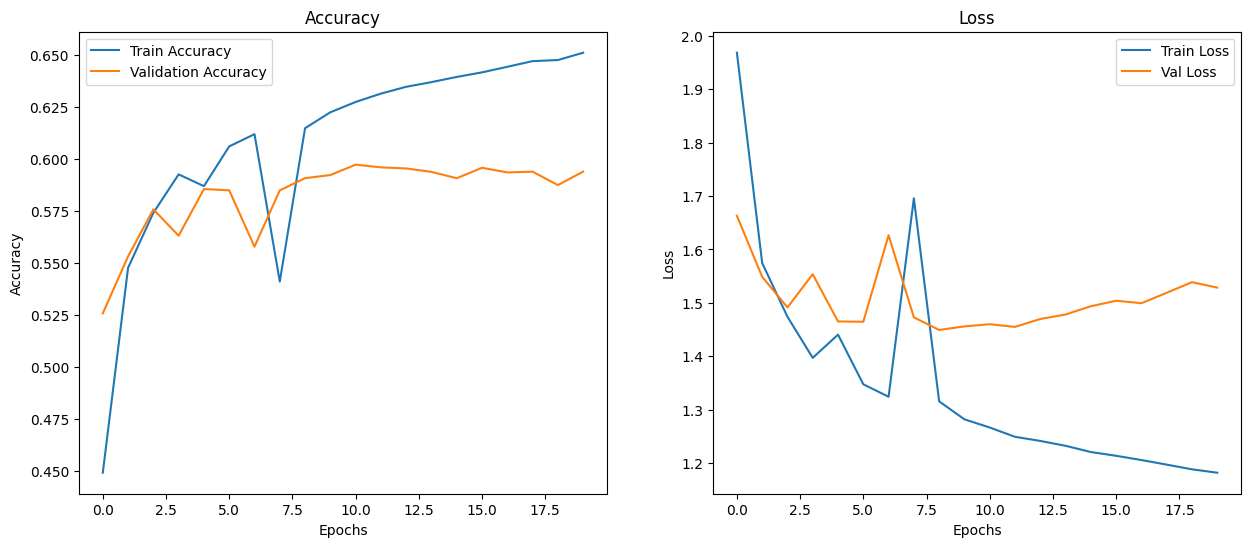

In [ ]:
plot_results(history.history)

### Model 6: Base GRU Model

In [ ]:
model = keras.models.Sequential()
model.add(layers.GRU(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               82944     
                                                                 
 dense (Dense)               (None, 86)                11094     
                                                                 
Total params: 94038 (367.34 KB)
Trainable params: 94038 (367.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                epochs=20,
                batch_size=64,
                validation_split=0.2)

Epoch 1/20
2257/2257 [==============================] - 15s 6ms/step - loss: 1.9346 - acc: 0.4560 - val_loss: 1.7398 - val_acc: 0.5116
Epoch 2/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.6883 - acc: 0.5177 - val_loss: 1.7196 - val_acc: 0.5160
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.7198 - acc: 0.5096 - val_loss: 1.8868 - val_acc: 0.4707
Epoch 4/20
2257/2257 [==============================] - 12s 5ms/step - loss: 2.3136 - acc: 0.3634 - val_loss: 2.6103 - val_acc: 0.2940
Epoch 5/20
2257/2257 [==============================] - 12s 5ms/step - loss: 2.5263 - acc: 0.3110 - val_loss: 2.5302 - val_acc: 0.3213
Epoch 6/20
2257/2257 [==============================] - 12s 5ms/step - loss: 2.5234 - acc: 0.3128 - val_loss: 2.6188 - val_acc: 0.2934
Epoch 7/20
2257/2257 [==============================] - 12s 5ms/step - loss: 2.5728 - acc: 0.2978 - val_loss: 2.5629 - val_acc: 0.3056
Epoch 8/20
2257/2257 [==============================] -

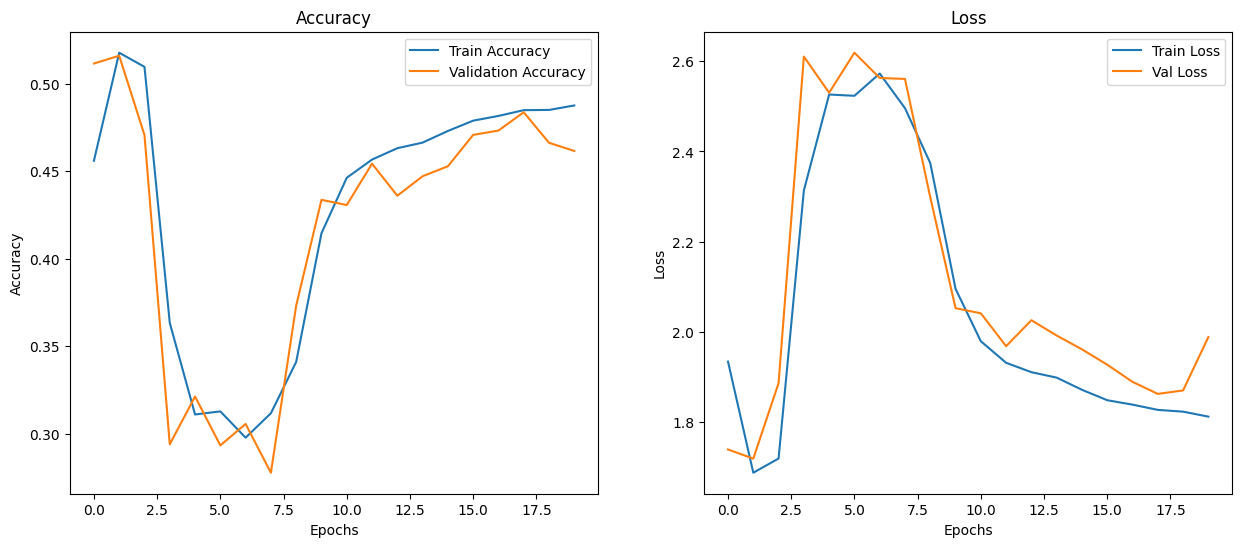

In [ ]:
plot_results(history.history)

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more slass and said some said said and said said said some some said some slass and some slass as starry 
 BLEU Score: 0.06543050862635517

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more some sages looked and of 
sigemens shomes slays of lass lass as and said casss as of the stroomass s
 BLEU Score: 0.17007533042404502

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more chansping sounged strale hell. ences slesassepsore, somat becezeain looked slem and sicked liflass s
 BLEU Score: 0.07679307787192961



### Model 7: GRU RMSProp Learning Rate

In [ ]:
hyperparameter_name = 'learning_rate'
params = {hyperparameter_name :[0.001, 0.005, 0.01, 0.1]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.GRU(128, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = value)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

learning_rate 0.001
model 0.001
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 128)               82944     
                                                                 
 dense_19 (Dense)            (None, 86)                11094     
                                                                 
Total params: 94038 (367.34 KB)
Trainable params: 94038 (367.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 14s 6ms/step - loss: 2.3901 - acc: 0.3477 - val_loss: 2.0840 - val_acc: 0.4173
Epoch 2/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.9659 - acc: 0.4504 - val_loss: 1.8687 - val_acc: 0.4732
Epoch 3/20
2257/2257 [==============================] - 12s 5ms/step - loss: 1.8033 - acc: 0.4899 - val_loss:

<ipython-input-16-0fd1ee987549>:50: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])


1411/1411 [==============================] - 3s 2ms/step


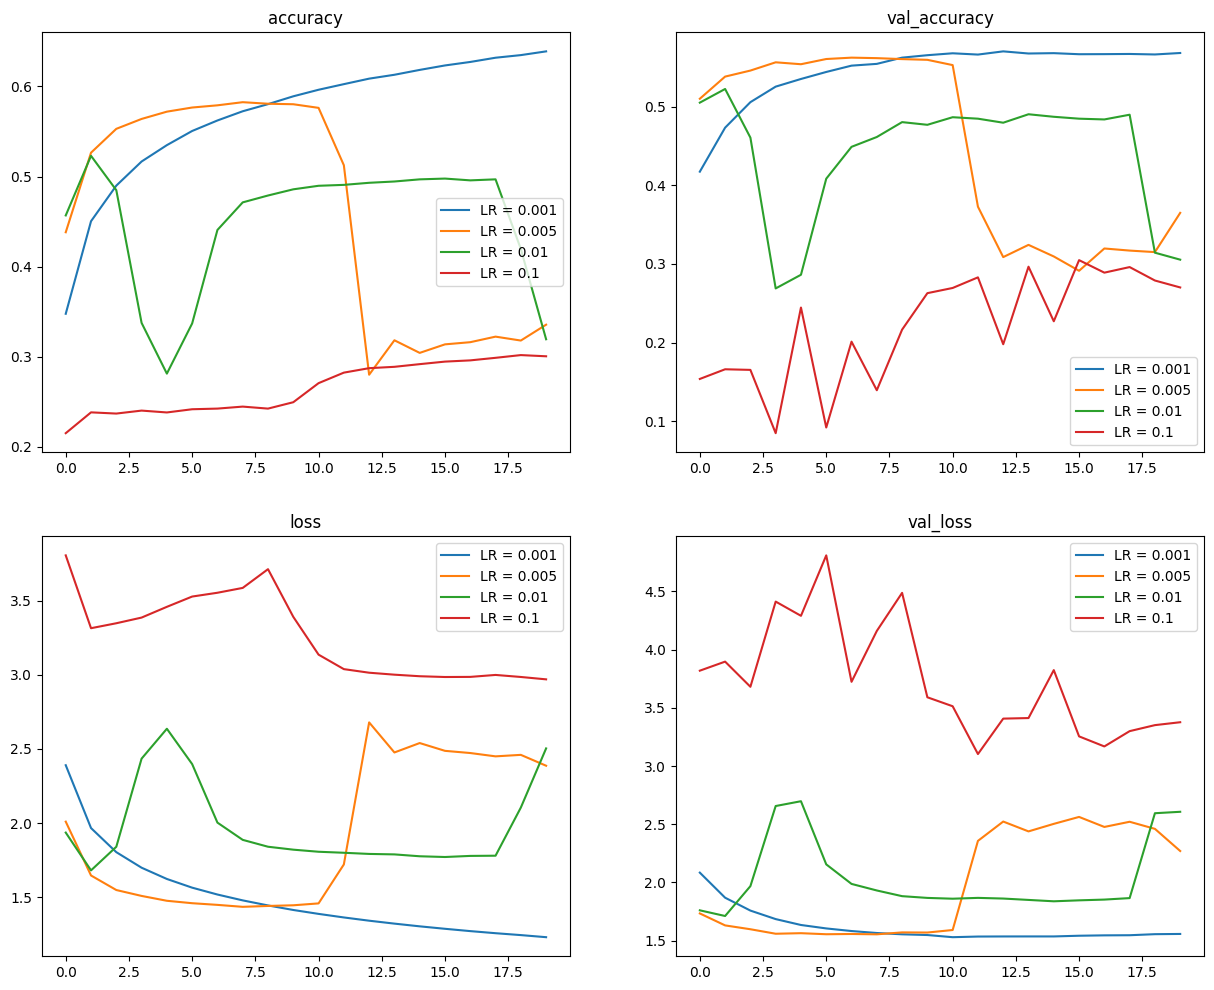

In [ ]:
plot_results_multi(histories, ["LR = 0.001", "LR = 0.005", "LR = 0.01", "LR = 0.1"])

In [ ]:
selected_value = 0.001  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
sighted at the 
common room that the three and the three and the stairs to the 
table pored 
that h
 BLEU Score: 0.2552325633124593

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
cold of the treak 



Page | 2h Harry Potter and the Prisoner of Azkaban - J.K. Rowling 




“It wa
 BLEU Score: 0.20727022076426313

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more lookedning all the cream.” Onink to ’sentened,” said Trombeedly. “I’ve reappeared of his hand’s like
 BLEU Score: 0.08730732866697923



### Model 8: GRU Batch Sizes

In [ ]:
hyperparameter_name = 'batch_size'
params = {hyperparameter_name :[16, 32, 64, 128]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.GRU(128, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=value,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

batch_size 16
model 16
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 128)               82944     
                                                                 
 dense_23 (Dense)            (None, 86)                11094     
                                                                 
Total params: 94038 (367.34 KB)
Trainable params: 94038 (367.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
9026/9026 [==============================] - 52s 6ms/step - loss: 2.2196 - acc: 0.3948 - val_loss: 1.9365 - val_acc: 0.4723
Epoch 2/20
9026/9026 [==============================] - 48s 5ms/step - loss: 1.8334 - acc: 0.4936 - val_loss: 1.7681 - val_acc: 0.5145
Epoch 3/20
9026/9026 [==============================] - 48s 5ms/step - loss: 1.7075 - acc: 0.5268 - val_loss: 1.7099 -

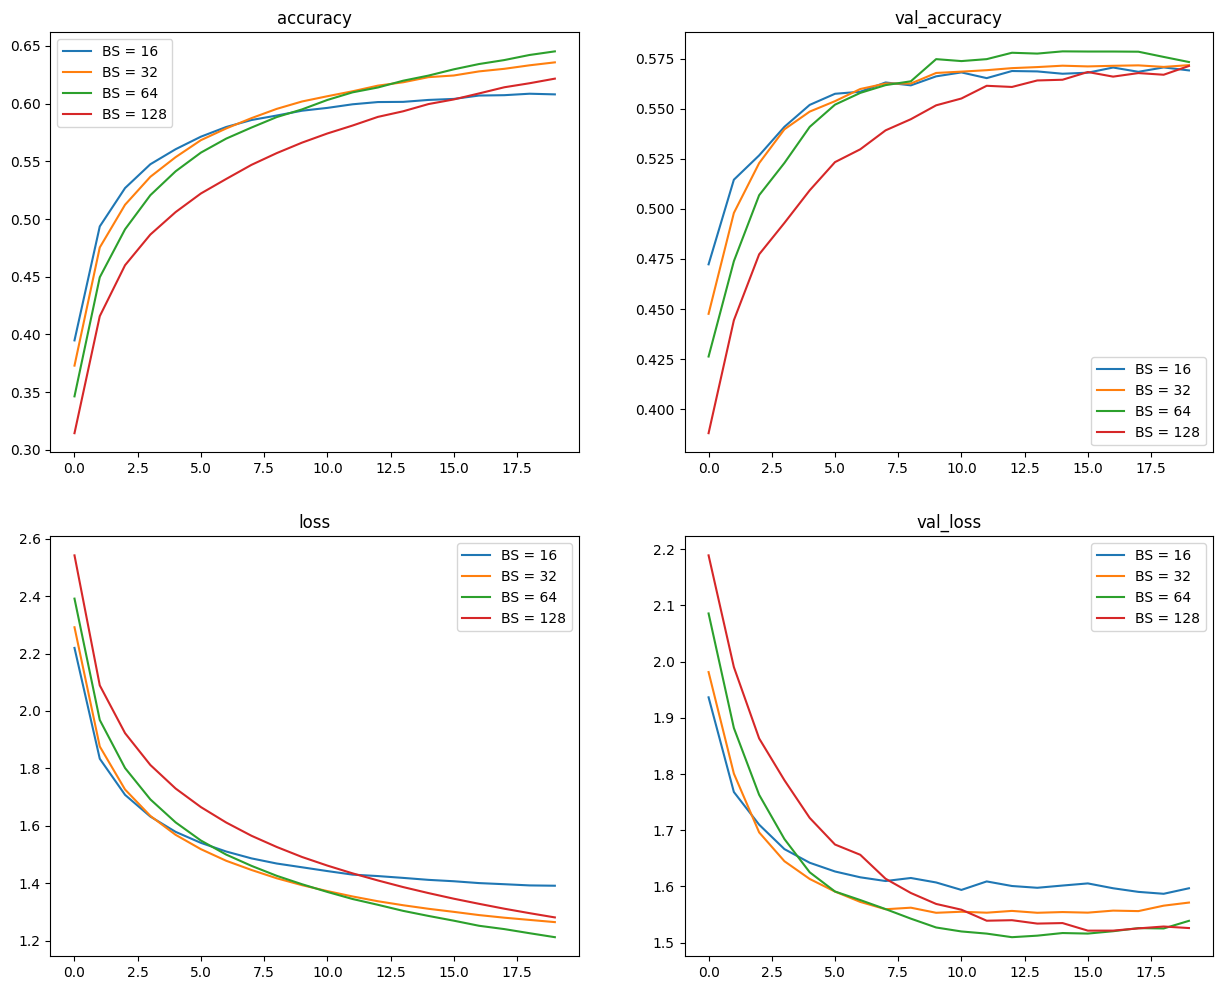

In [ ]:
plot_results_multi(histories, ["BS = 16", "BS = 32", "BS = 64", "BS = 128"])

128 performs only slightly worse than 64 with lesser overfitting

In [ ]:
selected_value = 128  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more the 
stairs. 

“What was strough the 
staircase 
the 
stairs 
and 
was staring in a 
friends of the 
 BLEU Score: 0.15621821341759376

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more to the 
tording the toush his pormon of a side of the 
anered it a fiffing presside. 

“All with him
 BLEU Score: 0.1774956128232151

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more to Hogwarts. 

He taiding from beepet to hild manation “you sew goady 
herted the larg would ppeared
 BLEU Score: 0.2227263469957047



### Model 9: GRU Layer Sizes

In [ ]:
hyperparameter_name = 'layer_size'
params = {hyperparameter_name :[64, 96, 128, 160]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.GRU(value, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

layer_size 64
model 64
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 64)                29184     
                                                                 
 dense_27 (Dense)            (None, 86)                5590      
                                                                 
Total params: 34774 (135.84 KB)
Trainable params: 34774 (135.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1129/1129 [==============================] - 8s 6ms/step - loss: 2.6789 - acc: 0.2837 - val_loss: 2.3118 - val_acc: 0.3576
Epoch 2/20
1129/1129 [==============================] - 6s 5ms/step - loss: 2.2108 - acc: 0.3801 - val_loss: 2.1354 - val_acc: 0.4074
Epoch 3/20
1129/1129 [==============================] - 6s 5ms/step - loss: 2.0575 - acc: 0.4248 - val_loss: 1.9998 - va

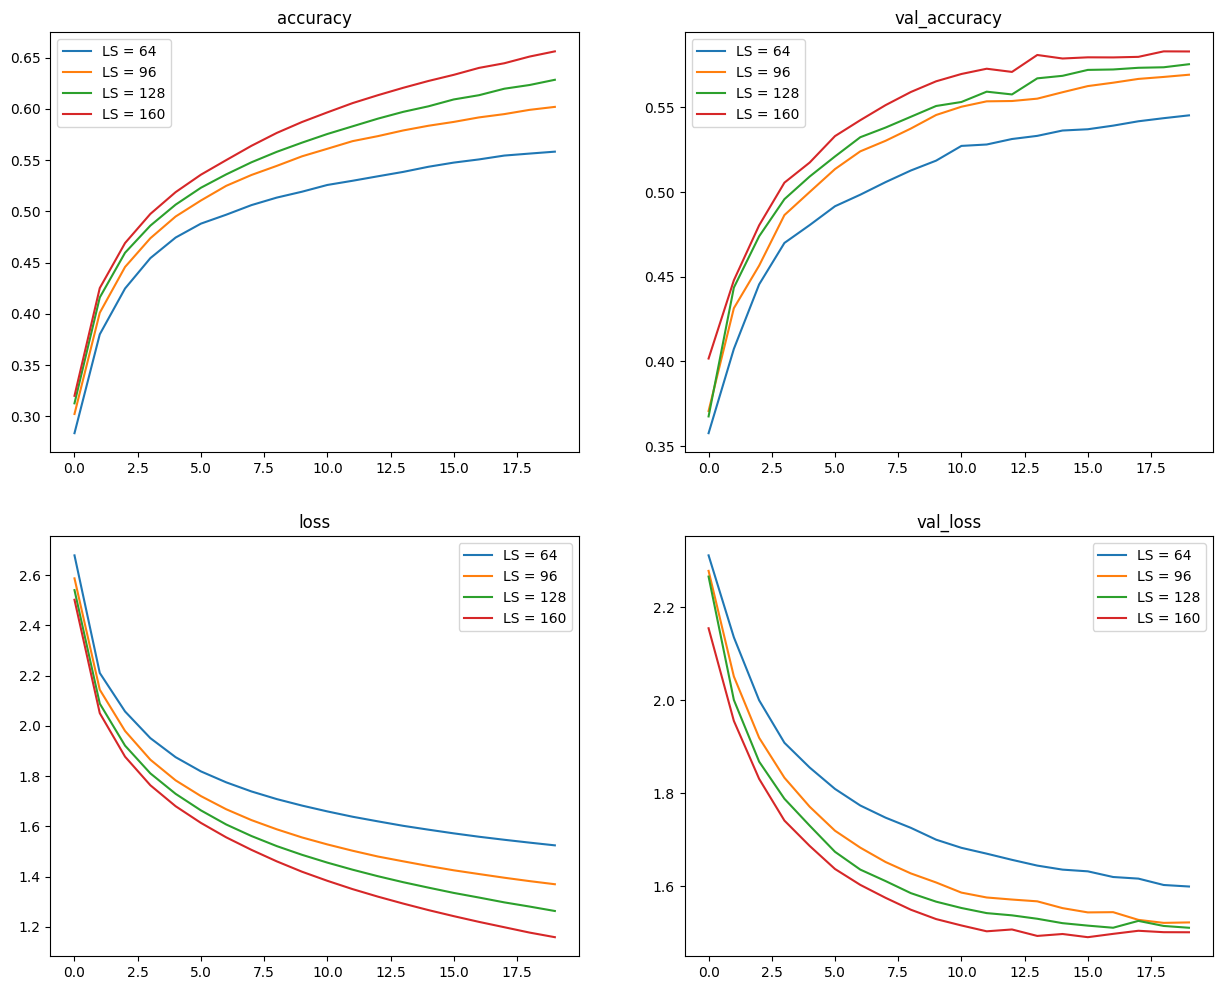

In [ ]:
plot_results_multi(histories, ["LS = 64", "LS = 96", "LS = 128", "LS = 160"])

Only slightly better, 0.58 (LS = 160) vs 0.57.5 (LS = 128).

All three layer sizes, 96, 128 and 160 have small differences between validation scores but with different variances. LS = 160 has the best performance but the most variance, LS = 96 has the worst performance of the three but the least variance.

Choose layer size 128 as it is in between the performance and variance tradeoff. Do not sacrifice as much performance for a smaller variance.

In [ ]:
selected_value = 128  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
the common room was a long to the books and 
and staring and really could have the cormarat of the 
 BLEU Score: 0.21107904565113558

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
because Hagrid, what everyone looked as he was to 
stopt of the startion, and the corner on 
Harry 
 BLEU Score: 0.2868169198578503

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
deen 
any naste diddrace. He lest hur.” 

the door on,” said Patat out awoth firchived him, or 
aga
 BLEU Score: 0.1882769319103367



### Final GRU Model

In [ ]:
model = keras.models.Sequential()
model.add(layers.GRU(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()


history = model.fit(x_train, y_train,
                epochs=20,
                batch_size=128,
                validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               82944     
                                                                 
 dense_1 (Dense)             (None, 86)                11094     
                                                                 
Total params: 94038 (367.34 KB)
Trainable params: 94038 (367.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1129/1129 [==============================] - 10s 8ms/step - loss: 2.5338 - acc: 0.3139 - val_loss: 2.2009 - val_acc: 0.3803
Epoch 2/20
1129/1129 [==============================] - 8s 7ms/step - loss: 2.0874 - acc: 0.4166 - val_loss: 1.9846 - val_acc: 0.4462
Epoch 3/20
1129/1129 [==============================] - 8s 7ms/step - loss: 1.9142 - acc: 0.4606 - val_loss: 1.8585 - val_acc: 0.4694
Epoch 4/2

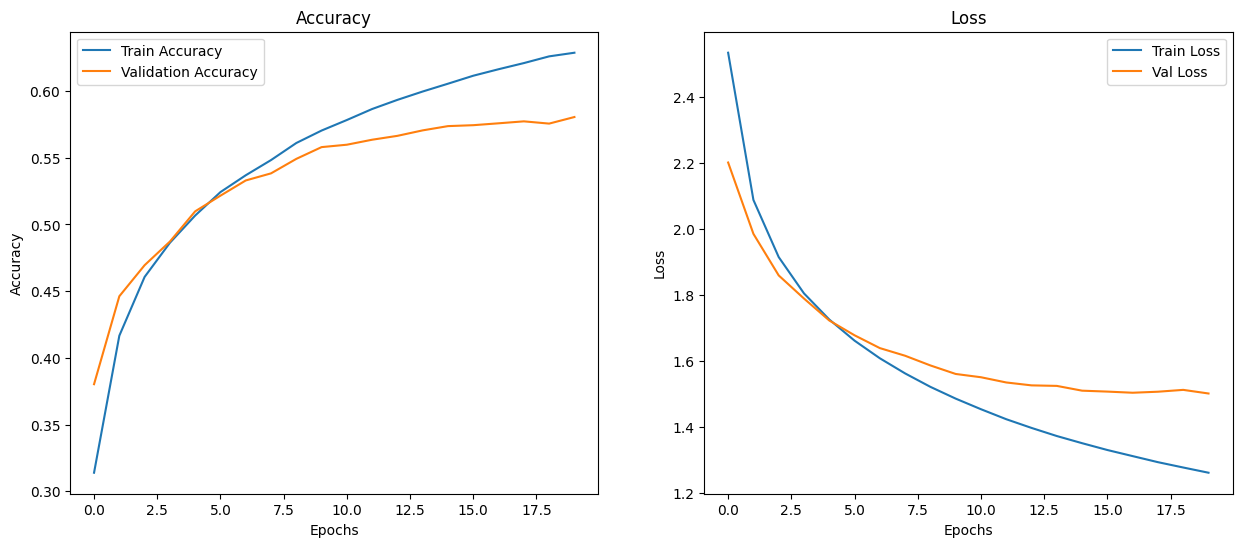

In [ ]:
plot_results(history.history)

### Choosing between LSTM and GRU

LSTM - peaked 0.59, around 0.585 to 0.589

GRU - peaked 0.575

LSTM is slightly better in terms of performance

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(160, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()


history = model.fit(x_train, y_train,
                  epochs=20,
                  batch_size=64,
                  validation_split=0.2)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 160)               158080    
                                                                 
 dense_35 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 17s 7ms/step - loss: 1.9634 - acc: 0.4490 - val_loss: 1.6665 - val_acc: 0.5269
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.5815 - acc: 0.5431 - val_loss: 1.5691 - val_acc: 0.5521
Epoch 3/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.4765 - acc: 0.5690 - val_loss: 1.5244 - val_acc: 0.5632
Epoc

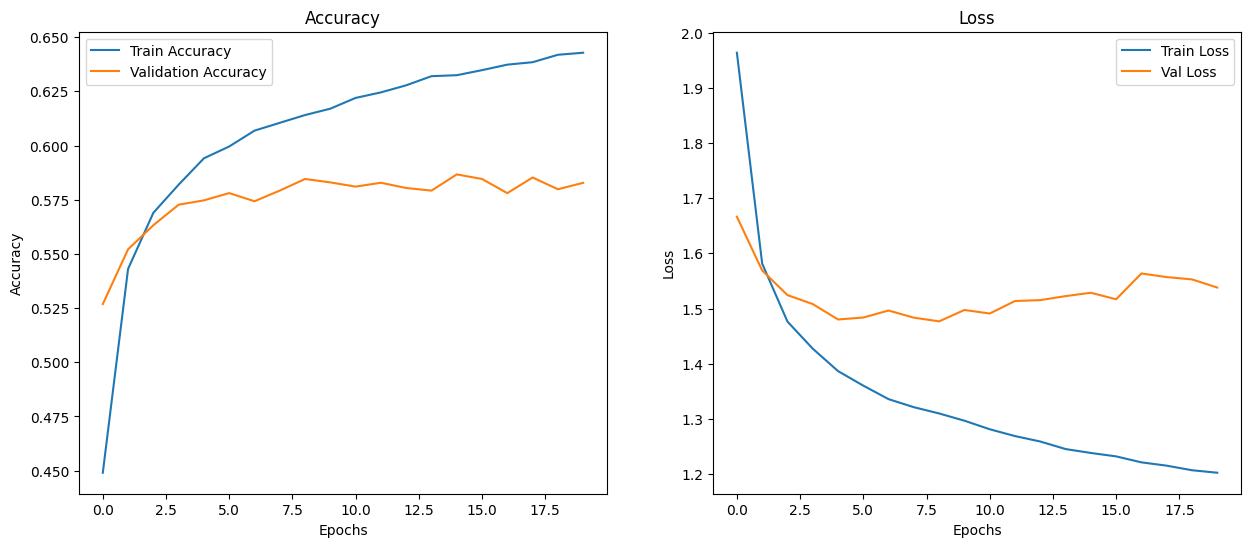

In [ ]:
plot_results(history.history)

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more thing and 
someone standing in the 
stairs to the 
staircase. 

“Kecventered in the 
Marge, Harry!” 
 BLEU Score: 0.17237313151604763

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more realizing their 
suddenly 
one of 
lost again, and he sat down of the face like the and were 
front 
 BLEU Score: 0.25385313987323377

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more face, 
Ron approad up. ... “It’s same Heat.” 

Verning Weasless sodwall, still 
sometwiousneed to Ha
 BLEU Score: 0.11145586036417451



### Model 10: Adam Optimizer

Try Adam Optimizer

In [ ]:
hyperparameter_name = 'learning_rate'
params = {hyperparameter_name :[0.001, 0.005, 0.01, 0.1]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(160, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.Adam(learning_rate = value)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

learning_rate 0.001
model 0.001
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 160)               158080    
                                                                 
 dense_36 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 17s 7ms/step - loss: 2.5282 - acc: 0.3157 - val_loss: 2.1928 - val_acc: 0.3929
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 2.0739 - acc: 0.4174 - val_loss: 1.9775 - val_acc: 0.4428
Epoch 3/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.9105 - acc: 0.4591 - val_los

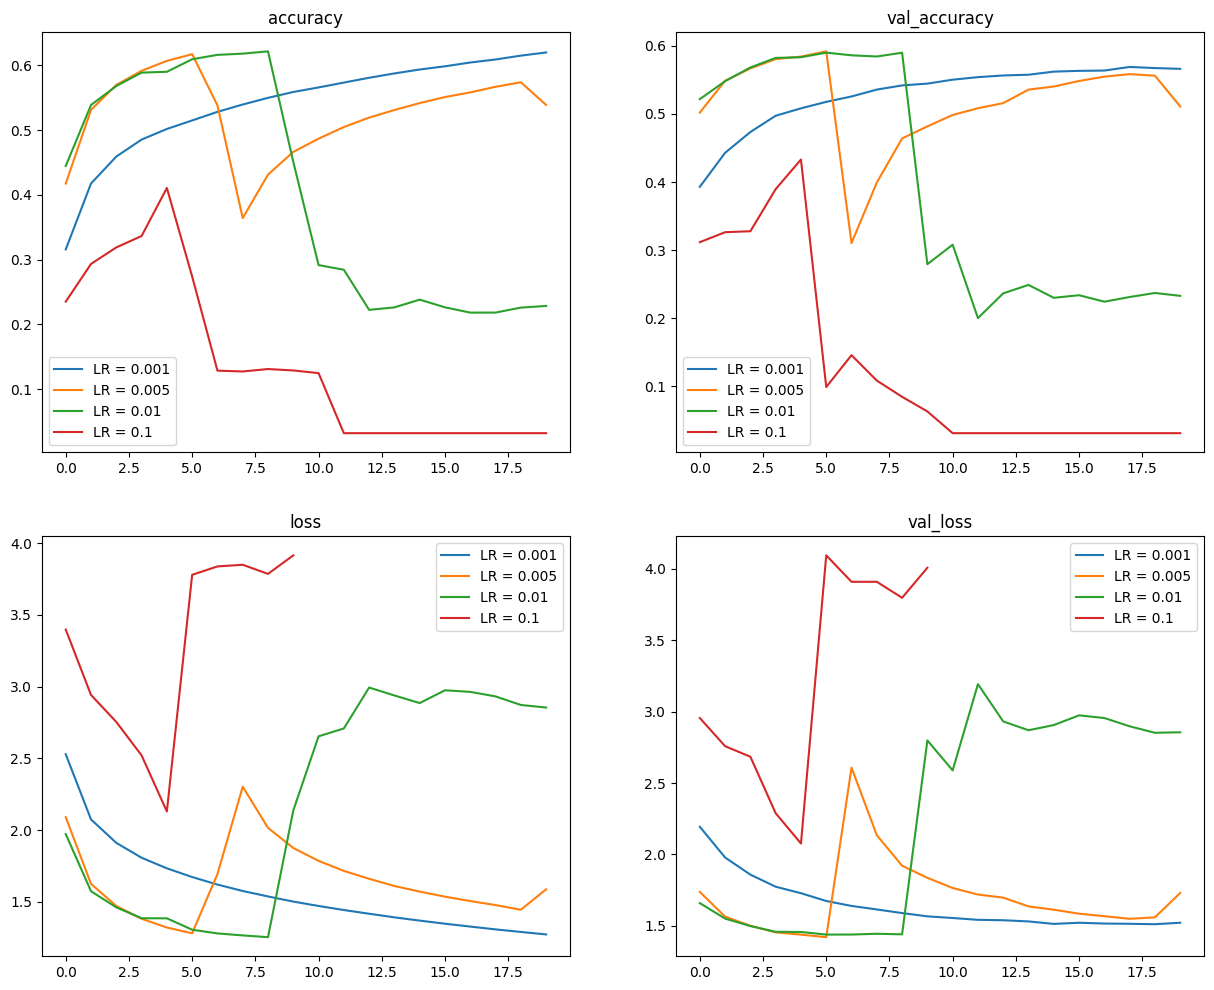

In [ ]:
plot_results_multi(histories, ["LR = 0.001", "LR = 0.005", "LR = 0.01", "LR = 0.1"])


In [ ]:
selected_value = 0.001  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more to say to 
snow he was the 
door of the 
door and say to the 
say the teacher to have the table of 

 BLEU Score: 0.2244463692868187

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more to a said and seathed the carried himself to said with a sure books out of the last out of the top o
 BLEU Score: 0.17124430182771444

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more Marge. 

“NEsOoys 
he moude glany, room and, pien Ron had way voice. Though a like Malfoy. Nevilce 

 BLEU Score: 0.1152393753189546



Adam seems to be slightly worse, continue using RMSProp

### Model 11: Activation Functions 

#### ReLU and Sigmoid

In [ ]:
hyperparameter_name = 'activation_function'
params = {hyperparameter_name :["relu", "sigmoid"]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(160, activation = value, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

activation_function relu
model relu
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 160)               158080    
                                                                 
 dense_25 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 124s 54ms/step - loss: 103652355300461731510264791040.0000 - acc: 0.1742 - val_loss: 103998599210985733897332981760.0000 - val_acc: 0.1752
Epoch 2/20
2257/2257 [==============================] - 118s 52ms/step - loss: 103736913994703995377461231616.0000 - acc: 0.1743 - val_loss: 103998693658315391290237255680.0000 -

<ipython-input-12-0fd1ee987549>:50: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(predictions_flat[np.where(y_test_flat == 1)])


1411/1411 [==============================] - 15s 10ms/step


activation_function sigmoid
model sigmoid
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 160)               158080    
                                                                 
 dense_26 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 120s 53ms/step - loss: 2.2177 - acc: 0.3822 - val_loss: 1.9000 - val_acc: 0.4633
Epoch 2/20
2257/2257 [==============================] - 117s 52ms/step - loss: 1.7723 - acc: 0.4931 - val_loss: 1.7031 - val_acc: 0.5130
Epoch 3/20
2257/2257 [==============================] - 119s 53ms/step - loss: 1.6422 - acc: 

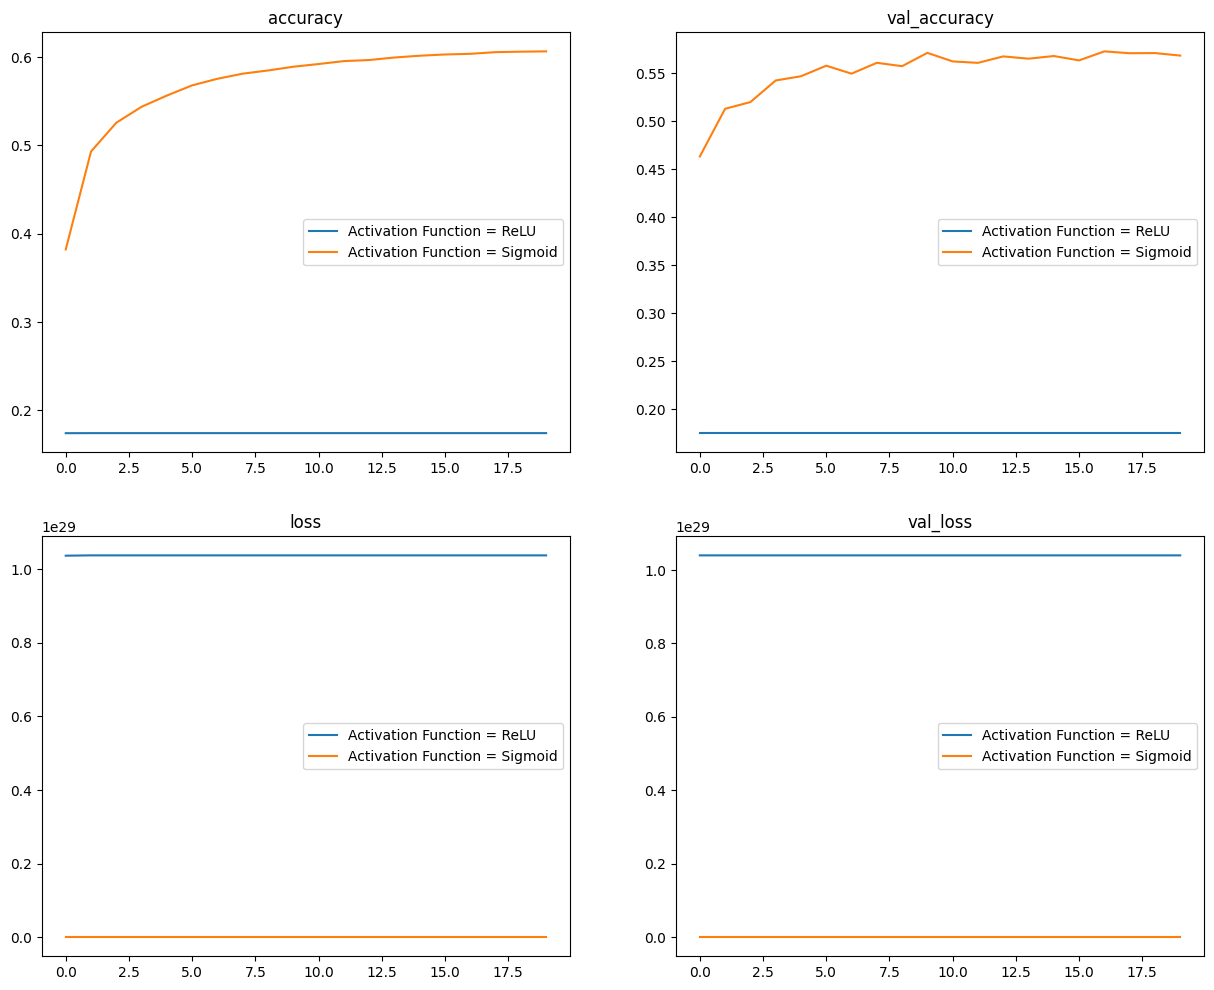

In [ ]:
plot_results_multi(histories, ["Activation Function = ReLU", "Activation Function = Sigmoid"])

#### LeakyReLU

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(160, input_shape=(maxlen, len(chars))))
model.add(layers.LeakyReLU())
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

model.summary()


history = model.fit(x_train, y_train,
                epochs=20,
                batch_size=64,
                validation_split=0.2)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 160)               158080    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 160)               0         
                                                                 
 dense_41 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 17s 7ms/step - loss: 2.0072 - acc: 0.4361 - val_loss: 1.7061 - val_acc: 0.5105
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.5882 - acc: 0.5396 - val_loss: 1.5673 - val_acc: 0.5478
Epoch 3

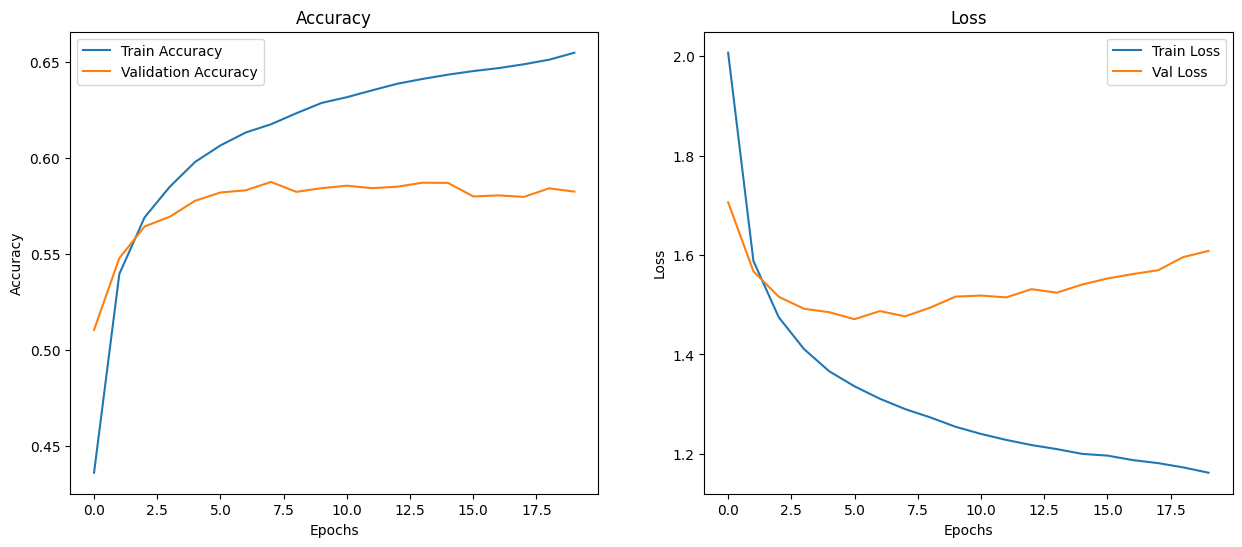

In [ ]:
plot_results(history.history)

In [ ]:
create_new_text(model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more and 
Ron and 
Ron and straighten on the stairs. 

“I’ve got — ” 

“I see you can you have been a cor
 BLEU Score: 0.10431920765234771

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more and 
passed the corner in the cases of 
his bedis of the back of the can try soed again. 

“I didn’t
 BLEU Score: 0.17909361134900925

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more and hear a large 
and George about num liked, and stried into 
the 
beans down!use themself into the
 BLEU Score: 0.18035936932897403



TanH is very slightly better in terms of variance, deviation of curves is lesser with TanH

### Model 12: Kernel Initializers

In [ ]:
hyperparameter_name = 'kernel_initializer'
params = {hyperparameter_name :["glorot_uniform", "orthogonal", "HeNormal", "lecun_uniform"]}

histories = []
perplexity = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(160, kernel_initializer = value, input_shape=(maxlen, len(chars))))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    perplexity.append(evaluate_model(model))

    trained_models[value] = model

kernel_initializer glorot_uniform
model glorot_uniform
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 160)               158080    
                                                                 
 dense_42 (Dense)            (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 16s 7ms/step - loss: 2.0105 - acc: 0.4393 - val_loss: 1.6777 - val_acc: 0.5154
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.5921 - acc: 0.5404 - val_loss: 1.5630 - val_acc: 0.5513
Epoch 3/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.4796 

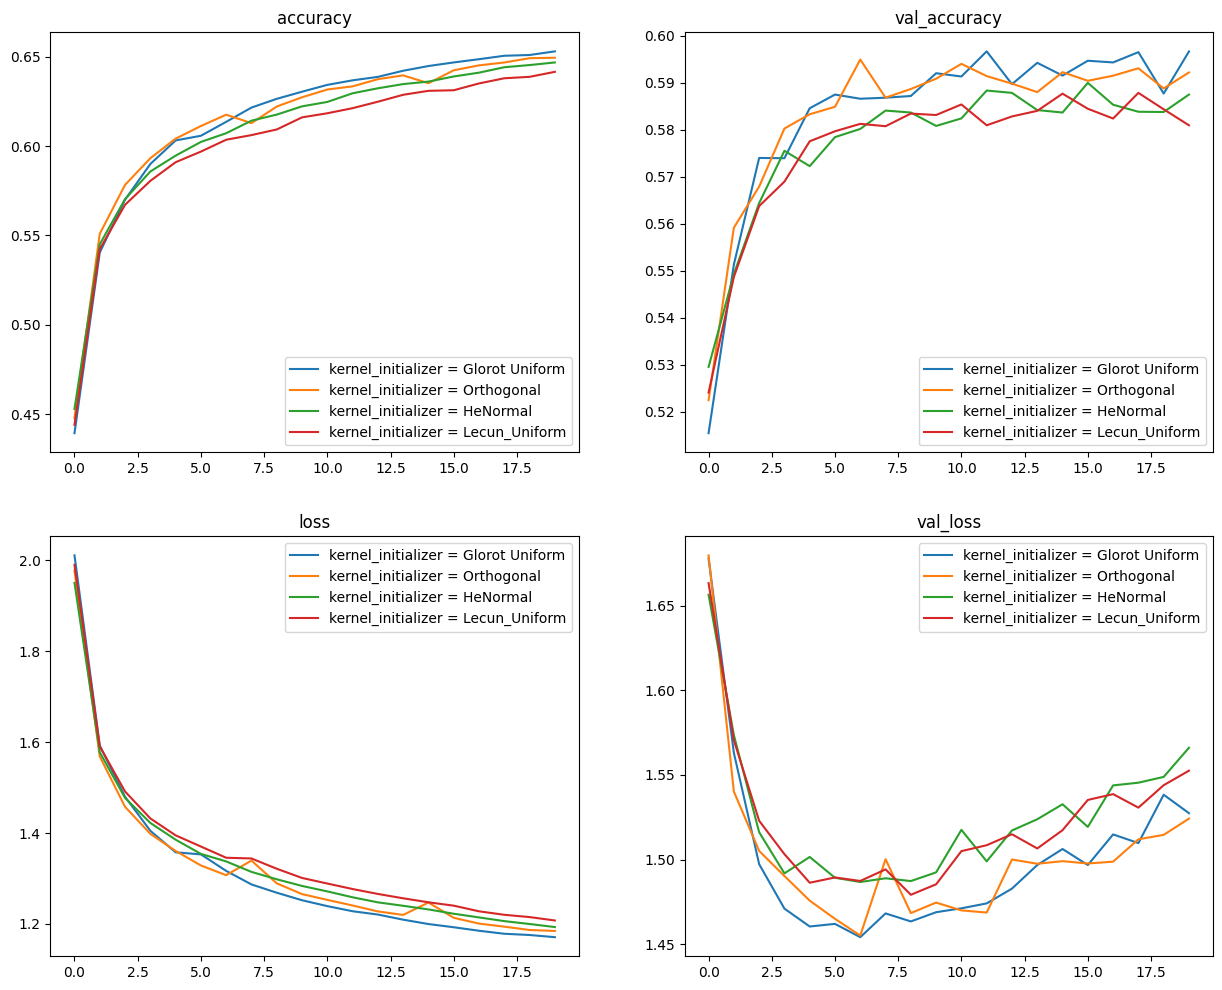

In [ ]:
plot_results_multi(histories, ["kernel_initializer = Glorot Uniform", "kernel_initializer = Orthogonal", "kernel_initializer = HeNormal", "kernel_initializer = Lecun_Uniform"])

In [ ]:
selected_value = "glorot_uniform"  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
and the hall a start of the time that he had been a 
long like that he had been a speak, the hall a
 BLEU Score: 0.26077317767522434

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
that Harry followed his eyes, looking rack into his glicker. 
He was going to be falling a large ca
 BLEU Score: 0.09305404437602775

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more after 
a long, at the match, Ron, spirtedly, said Fred and 
calloning up littly spilys, where the st
 BLEU Score: 0.22809710087807342



In [ ]:
selected_value = "orthogonal"  # Change this to the value you want to retrieve
selected_model = trained_models[selected_value]

create_new_text(selected_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
just the staircase. 

“Yeah, you all reach of the match started the match 
started to the dementor 
 BLEU Score: 0.24118331974257826

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
Quidditch daith witch the rest of the class as though 
Black was stat off at lost the castle, and t
 BLEU Score: 0.15936077937441762

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
"meard up angrro. 

“Unce Harry was just reliking that lot back to the 
mond of gyin. 

She didn’t 
 BLEU Score: 0.18408707168815167



### Model 13: Dropout Layers

In [ ]:
hyperparameter_name = 'dropout rate'
params = {hyperparameter_name : [0.2, 0.3, 0.4, 0.5]}

histories = []
trained_models = {}

for value in params[hyperparameter_name]:
    print(hyperparameter_name, value)

    model_name = "model" + " " + str(value)
    print(model_name)

    model = keras.models.Sequential()
    model.add(layers.LSTM(160, kernel_initializer = "glorot_uniform", input_shape=(maxlen, len(chars))))
    model.add(layers.Dropout(value))
    model.add(layers.Dense(len(chars), activation='softmax'))

    optimizer = optimizers.RMSprop(learning_rate = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

    model.summary()


    history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

    histories.append(history)

    trained_models[value] = model

dropout rate 0.2
model 0.2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 160)               158080    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 17s 6ms/step - loss: 2.0434 - acc: 0.4323 - val_loss: 1.7212 - val_acc: 0.5138
Epoch 2/20
2257/2257 [==============================] - 14s 6ms/step - loss: 1.6777 - acc: 0.5224 - val_loss: 1.5950

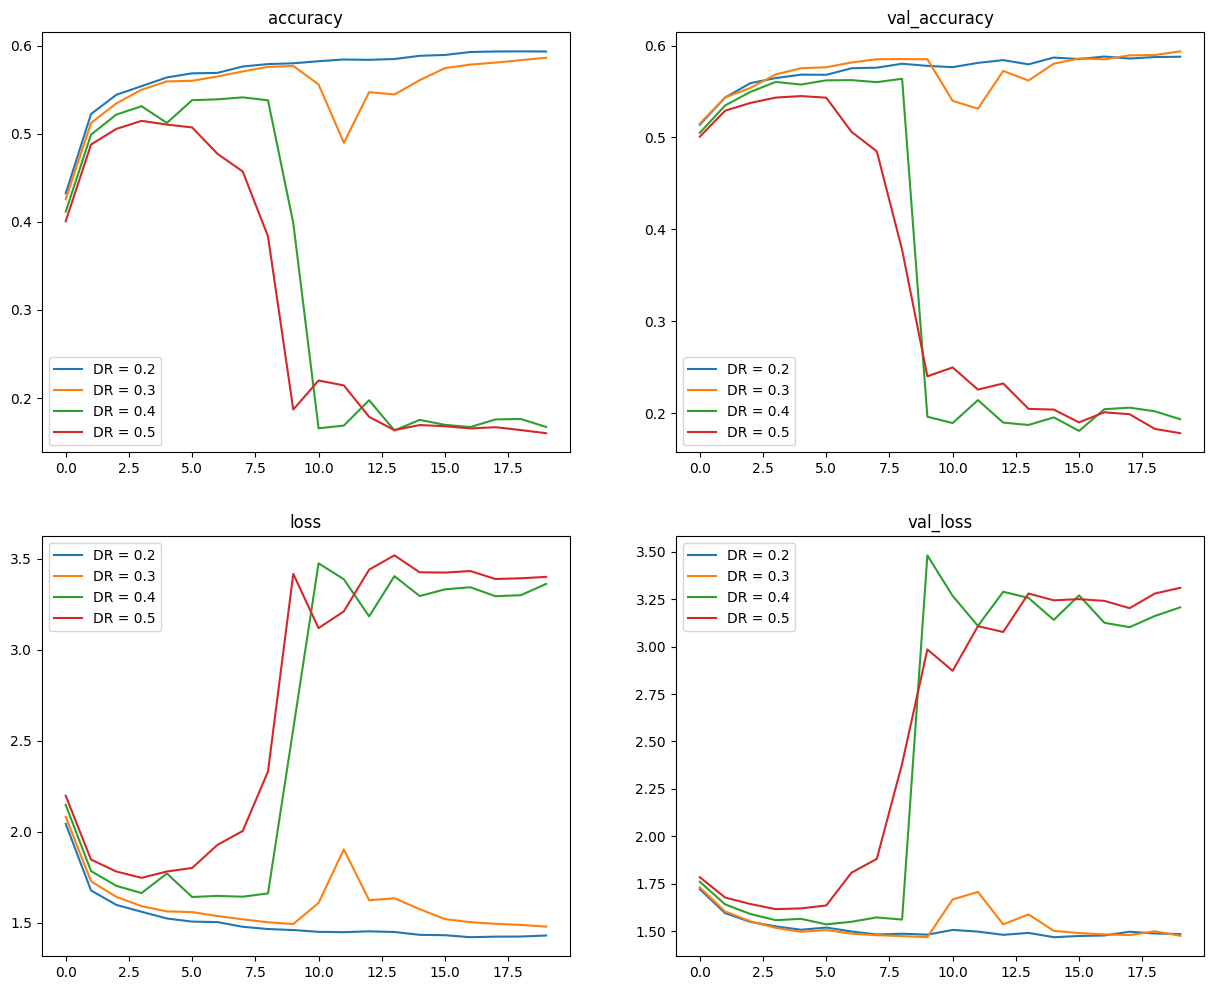

In [ ]:
plot_results_multi(histories, ["DR = 0.2", "DR = 0.3", "DR = 0.4", "DR = 0.5"])

Use DR = 0.2, validation performance decrease not too bad and train is very close to test. Less fluctuations in validation curves showing less sensitivity to noise hence lesser overfitting than 0.3

### Final Model

In [16]:
final_model = keras.models.Sequential()
final_model.add(layers.LSTM(160, input_shape=(maxlen, len(chars))))
final_model.add(layers.Dropout(0.2))
final_model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate = 0.01)
final_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = "acc")

final_model.summary()


history = final_model.fit(x_train, y_train,
                epochs=20,
                batch_size=64,
                validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 160)               158080    
                                                                 
 dropout_5 (Dropout)         (None, 160)               0         
                                                                 
 dense_5 (Dense)             (None, 86)                13846     
                                                                 
Total params: 171926 (671.59 KB)
Trainable params: 171926 (671.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2257/2257 [==============================] - 15s 6ms/step - loss: 2.0450 - acc: 0.4310 - val_loss: 1.7264 - val_acc: 0.5070
Epoch 2/20
2257/2257 [==============================] - 13s 6ms/step - loss: 1.6823 - acc: 0.5216 - val_loss: 1.5856 - val_acc: 0.5497
Epoch 3/

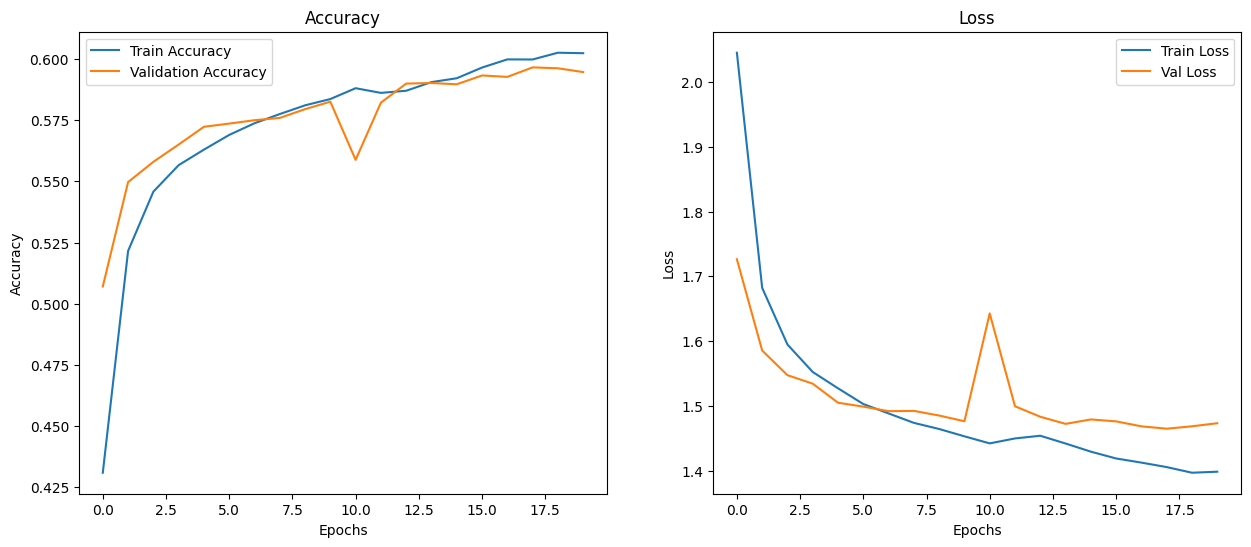

In [17]:
plot_results(history.history)

In [18]:
final_model.evaluate(x_test, y_test)

1411/1411 [==============================] - 5s 3ms/step - loss: 1.4653 - acc: 0.5965


[1.465329885482788, 0.5965254306793213]

In [20]:
final_model.save('Problem2_Final_Model.keras')

## Step 3 – Use the developed Model to generate the characters / sentences

**Stochastic Sampling with Temperature**

In [65]:
create_new_text(final_model)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "
------ temperature: 0.2
any ways. 
For one thing, he hated the summer holidays more 
had the last on the corner, and he was 
start the corner. 

“Sirius Black and the teachers was a st
 BLEU Score: 0.20981388950364085

------ temperature: 0.5
any ways. 
For one thing, he hated the summer holidays more 
to finger the happing the carculates, the 
said, “I says of the front of Azkaban and Harry was real
 BLEU Score: 0.22291172072834906

------ temperature: 1.0
any ways. 
For one thing, he hated the summer holidays more 
had anything of it. 

“Can this durted, Diggory on the ant morning another 
omene the you want of i
 BLEU Score: 0.28392149738058403



**Top K Sampling**

In [27]:
def top_k_sampling(preds, k=5): # use top 5
    top_indices = np.argsort(preds)[-k:]
    top_probs = preds[top_indices] / np.sum(preds[top_indices])
    selected_index = np.random.choice(top_indices, p=top_probs)
    return selected_index

In [51]:
def create_new_text_with_top_k(model, k=5):
    start_index = 60
    generated_text_initial = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text_initial + '"')

    generated_text = generated_text_initial

    for i in range(100):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = top_k_sampling(preds, k)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()

    bleu_score = calculate_bleu_score(generated_text_initial, generated_text)
    print("\n BLEU Score:", bleu_score)

    print()

In [52]:
create_new_text_with_top_k(final_model, k = 5)

--- Generating with seed: "any ways. 
For one thing, he hated the summer holidays more "

anything with something his fass was a sached his fape 
toward the said, “is a face. “What was now 
 BLEU Score: 0.21760277520925145



**User Input**

In [70]:
# takes the user input
text_input = np.array([input()])

Hagrid raised a gigantic fist and knocked three times on the castle door.


In [71]:
length_of_text_input = len(text_input[0])

print("Length of text_input:", length_of_text_input)

Length of text_input: 73


In [72]:
input_text = text_input[0]

In [73]:
def create_new_text(model):
  #start_index = random.randint(0, len(text) - maxlen - 1)
  #start_index = 60
  generated_text_initial = input_text
  print('--- Generating with seed: "' + generated_text_initial + '"')

  generated_text = generated_text_initial

  for i in range(400):
      sampled = np.zeros((1, len(input_text), len(chars)))
      for t, char in enumerate(generated_text):
          sampled[0, t, char_indices[char]] = 1.

      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature = 0.5)
      next_char = chars[next_index]

      generated_text += next_char
      generated_text = generated_text[1:]

      sys.stdout.write(next_char)
      sys.stdout.flush()

  print()


In [74]:
create_new_text(final_model)

--- Generating with seed: "Hagrid raised a gigantic fist and knocked three times on the castle door."
 

“And he can’t never prodetending him a some ter raished the remout of 
cear of the corner. He was he was the 
grounds had the telepe with a great 
think the teachers had start out of the completer 
that he was a carrily. 

“Seen in a low of his head been the rest of the train, who said 
there was a dementor and was a coming in 
the thirt of the one thing going to get at the scarte for the 
hold
